# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

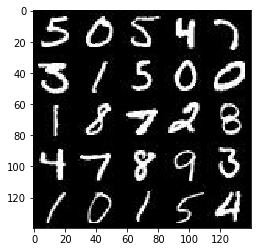

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

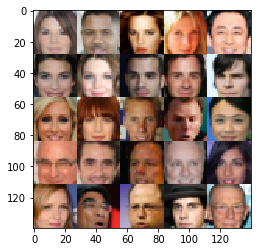

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    return tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='real_input'), \
        tf.placeholder(tf.float32, [None, z_dim], name='z_input'), \
        tf.placeholder(tf.float32, name='learning_rate')

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [49]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    alpha = 0.2
    keep_prob = 0.9
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        conv_layer1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', activation=None)
        conv_layer1 = tf.maximum(alpha * conv_layer1, conv_layer1)
        
        conv_layer2 = tf.layers.conv2d(conv_layer1, 128, 5, strides=2, padding='same', activation=None)
        conv_layer2 = tf.layers.batch_normalization(conv_layer2, training=True)
        conv_layer2 = tf.maximum(alpha * conv_layer2, conv_layer2)
        conv_layer2 = tf.nn.dropout(conv_layer2, keep_prob=keep_prob)
        
        conv_layer3 = tf.layers.conv2d(conv_layer2, 256, 5, strides=2, padding='same', activation=None)
        conv_layer3 = tf.layers.batch_normalization(conv_layer3, training=True)
        conv_layer3 = tf.maximum(alpha * conv_layer3, conv_layer3)
        conv_layer3 = tf.nn.dropout(conv_layer3, keep_prob=keep_prob)
        
        flat = tf.reshape(conv_layer3, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [50]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    alpha = 0.2
    keep_prob = 0.9
    reuse = not is_train
    
    with tf.variable_scope('generator', reuse=reuse):
        
        # First fully connected layer
        dense = tf.layers.dense(z, 2 * 2 * 512)
        
        # Reshape it to start the convolutional stack
        conv_layer1 = tf.reshape(dense, (-1, 2, 2, 512))
        conv_layer1 = tf.layers.batch_normalization(conv_layer1, training=is_train)
        conv_layer1 = tf.maximum(alpha * conv_layer1, conv_layer1)
        
        conv_layer2 = tf.layers.conv2d_transpose(conv_layer1, 256, 5, strides=2, padding='valid')
        conv_layer2 = tf.layers.batch_normalization(conv_layer2, training=is_train)
        conv_layer2 = tf.maximum(alpha * conv_layer2, conv_layer2)
        conv_layer2 = tf.nn.dropout(conv_layer2, keep_prob=keep_prob)
        
        conv_layer3 = tf.layers.conv2d_transpose(conv_layer2, 128, 5, strides=2, padding='same')
        conv_layer3 = tf.layers.batch_normalization(conv_layer3, training=is_train)
        conv_layer3 = tf.maximum(alpha * conv_layer3, conv_layer3)
        conv_layer3 = tf.nn.dropout(conv_layer3, keep_prob=keep_prob)
        
        logits = tf.layers.conv2d_transpose(conv_layer3, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [51]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [52]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    train_vars = tf.trainable_variables()
    d_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in train_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [53]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [54]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, image_width, image_height, image_channels = data_shape 
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every, show_every = 50, 500
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images *= 2.0
                
                # Run optimizers (generator 3 times, discriminator 2 times to allow the generator to catch up)
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate}) 
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate}) 
                    
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z, input_real: batch_images})
                    
                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
            
            show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
    
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.2638... Generator Loss: 4.1789
Epoch 1/2... Discriminator Loss: 0.7662... Generator Loss: 1.9623
Epoch 1/2... Discriminator Loss: 0.6782... Generator Loss: 1.6262
Epoch 1/2... Discriminator Loss: 1.0263... Generator Loss: 1.5334
Epoch 1/2... Discriminator Loss: 1.1134... Generator Loss: 0.9312
Epoch 1/2... Discriminator Loss: 1.0447... Generator Loss: 1.0487
Epoch 1/2... Discriminator Loss: 0.9646... Generator Loss: 1.1805
Epoch 1/2... Discriminator Loss: 0.9893... Generator Loss: 1.1039
Epoch 1/2... Discriminator Loss: 1.0977... Generator Loss: 1.0359
Epoch 1/2... Discriminator Loss: 0.9601... Generator Loss: 0.9575


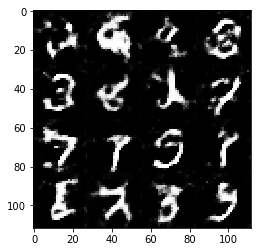

Epoch 1/2... Discriminator Loss: 1.1200... Generator Loss: 0.9793
Epoch 1/2... Discriminator Loss: 1.0121... Generator Loss: 1.0966
Epoch 1/2... Discriminator Loss: 1.1786... Generator Loss: 0.9260
Epoch 1/2... Discriminator Loss: 0.9357... Generator Loss: 0.9971
Epoch 1/2... Discriminator Loss: 1.0226... Generator Loss: 0.9840
Epoch 1/2... Discriminator Loss: 0.9587... Generator Loss: 1.0082
Epoch 1/2... Discriminator Loss: 0.9296... Generator Loss: 0.9698
Epoch 1/2... Discriminator Loss: 1.0718... Generator Loss: 1.0461
Epoch 1/2... Discriminator Loss: 0.9372... Generator Loss: 1.1440
Epoch 1/2... Discriminator Loss: 1.0733... Generator Loss: 1.1081


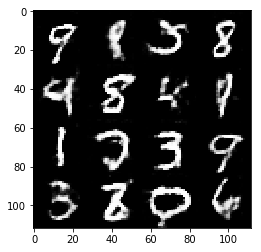

Epoch 1/2... Discriminator Loss: 0.9334... Generator Loss: 0.9177
Epoch 1/2... Discriminator Loss: 0.9048... Generator Loss: 1.2768
Epoch 1/2... Discriminator Loss: 0.9760... Generator Loss: 1.2493
Epoch 1/2... Discriminator Loss: 0.9678... Generator Loss: 1.1951
Epoch 1/2... Discriminator Loss: 0.9975... Generator Loss: 1.6205
Epoch 1/2... Discriminator Loss: 0.8361... Generator Loss: 1.2786
Epoch 1/2... Discriminator Loss: 0.9305... Generator Loss: 1.0363
Epoch 1/2... Discriminator Loss: 0.8532... Generator Loss: 1.5136
Epoch 1/2... Discriminator Loss: 1.0053... Generator Loss: 1.0003
Epoch 1/2... Discriminator Loss: 0.8479... Generator Loss: 1.0291


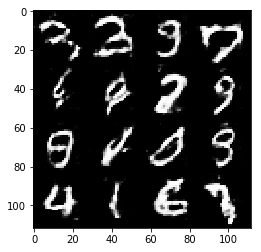

Epoch 1/2... Discriminator Loss: 0.7700... Generator Loss: 1.0734
Epoch 1/2... Discriminator Loss: 0.7982... Generator Loss: 1.1602
Epoch 1/2... Discriminator Loss: 0.7303... Generator Loss: 1.3173
Epoch 1/2... Discriminator Loss: 0.6781... Generator Loss: 1.7599
Epoch 1/2... Discriminator Loss: 0.7745... Generator Loss: 1.2063
Epoch 1/2... Discriminator Loss: 0.6062... Generator Loss: 1.4599
Epoch 1/2... Discriminator Loss: 0.6271... Generator Loss: 1.4183


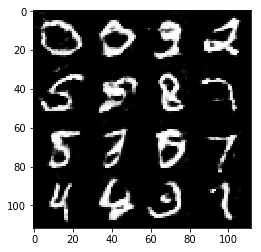

Epoch 2/2... Discriminator Loss: 0.7555... Generator Loss: 1.4446
Epoch 2/2... Discriminator Loss: 0.8008... Generator Loss: 1.8397
Epoch 2/2... Discriminator Loss: 0.5383... Generator Loss: 1.7611


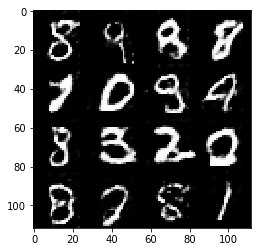

Epoch 2/2... Discriminator Loss: 0.6177... Generator Loss: 1.4368
Epoch 2/2... Discriminator Loss: 0.4931... Generator Loss: 1.3814
Epoch 2/2... Discriminator Loss: 0.6143... Generator Loss: 1.4675
Epoch 2/2... Discriminator Loss: 0.6642... Generator Loss: 1.9292
Epoch 2/2... Discriminator Loss: 0.5140... Generator Loss: 1.9083
Epoch 2/2... Discriminator Loss: 0.6308... Generator Loss: 1.1266
Epoch 2/2... Discriminator Loss: 0.4948... Generator Loss: 1.5788
Epoch 2/2... Discriminator Loss: 0.5435... Generator Loss: 1.5917
Epoch 2/2... Discriminator Loss: 0.5963... Generator Loss: 1.4287
Epoch 2/2... Discriminator Loss: 0.7305... Generator Loss: 1.6351


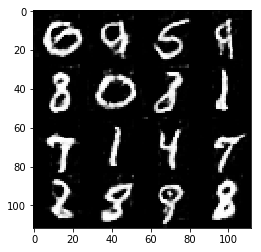

Epoch 2/2... Discriminator Loss: 0.3501... Generator Loss: 1.9958
Epoch 2/2... Discriminator Loss: 0.4335... Generator Loss: 1.6611
Epoch 2/2... Discriminator Loss: 0.4329... Generator Loss: 1.6003
Epoch 2/2... Discriminator Loss: 0.4389... Generator Loss: 1.7418
Epoch 2/2... Discriminator Loss: 0.3918... Generator Loss: 1.8541
Epoch 2/2... Discriminator Loss: 0.5492... Generator Loss: 1.6040
Epoch 2/2... Discriminator Loss: 0.5616... Generator Loss: 2.3629
Epoch 2/2... Discriminator Loss: 0.3791... Generator Loss: 1.8635
Epoch 2/2... Discriminator Loss: 0.4600... Generator Loss: 1.9095
Epoch 2/2... Discriminator Loss: 0.4748... Generator Loss: 1.9378


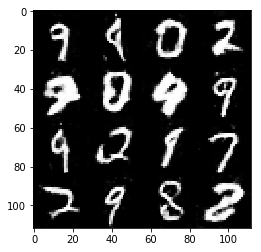

Epoch 2/2... Discriminator Loss: 0.4785... Generator Loss: 1.8735
Epoch 2/2... Discriminator Loss: 0.4432... Generator Loss: 1.9790
Epoch 2/2... Discriminator Loss: 0.4489... Generator Loss: 2.2526
Epoch 2/2... Discriminator Loss: 0.4071... Generator Loss: 1.4160
Epoch 2/2... Discriminator Loss: 0.4292... Generator Loss: 1.9043
Epoch 2/2... Discriminator Loss: 0.5103... Generator Loss: 1.5574
Epoch 2/2... Discriminator Loss: 0.3202... Generator Loss: 2.2058
Epoch 2/2... Discriminator Loss: 0.3426... Generator Loss: 2.5309
Epoch 2/2... Discriminator Loss: 0.3868... Generator Loss: 2.2708
Epoch 2/2... Discriminator Loss: 0.2646... Generator Loss: 1.7939


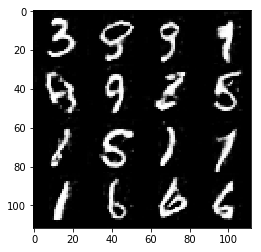

Epoch 2/2... Discriminator Loss: 0.5018... Generator Loss: 2.3423
Epoch 2/2... Discriminator Loss: 0.3162... Generator Loss: 2.1350
Epoch 2/2... Discriminator Loss: 0.4383... Generator Loss: 1.8411
Epoch 2/2... Discriminator Loss: 0.3876... Generator Loss: 1.9463
Epoch 2/2... Discriminator Loss: 0.2233... Generator Loss: 2.3024


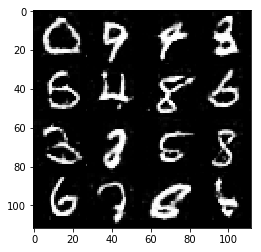

In [48]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.4803... Generator Loss: 4.5989
Epoch 1/1... Discriminator Loss: 0.7320... Generator Loss: 1.4566
Epoch 1/1... Discriminator Loss: 0.9582... Generator Loss: 1.2046
Epoch 1/1... Discriminator Loss: 1.2451... Generator Loss: 1.6116
Epoch 1/1... Discriminator Loss: 1.0980... Generator Loss: 0.9532
Epoch 1/1... Discriminator Loss: 1.3642... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 1.0517... Generator Loss: 1.0502
Epoch 1/1... Discriminator Loss: 1.1819... Generator Loss: 0.8403
Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.8212
Epoch 1/1... Discriminator Loss: 1.2999... Generator Loss: 1.1384


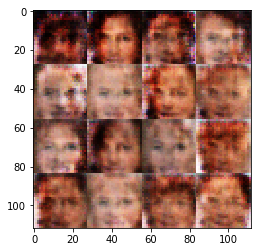

Epoch 1/1... Discriminator Loss: 1.2631... Generator Loss: 0.9938
Epoch 1/1... Discriminator Loss: 1.2642... Generator Loss: 0.8599
Epoch 1/1... Discriminator Loss: 1.2531... Generator Loss: 0.7444
Epoch 1/1... Discriminator Loss: 1.3340... Generator Loss: 0.7220
Epoch 1/1... Discriminator Loss: 1.4588... Generator Loss: 0.7697
Epoch 1/1... Discriminator Loss: 1.5374... Generator Loss: 0.5758
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.6677
Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.7321
Epoch 1/1... Discriminator Loss: 1.4946... Generator Loss: 0.5865
Epoch 1/1... Discriminator Loss: 1.4693... Generator Loss: 0.6627


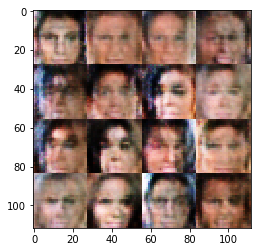

Epoch 1/1... Discriminator Loss: 1.3316... Generator Loss: 0.6454
Epoch 1/1... Discriminator Loss: 1.4051... Generator Loss: 0.6526
Epoch 1/1... Discriminator Loss: 1.4548... Generator Loss: 0.6227
Epoch 1/1... Discriminator Loss: 1.3212... Generator Loss: 0.7583
Epoch 1/1... Discriminator Loss: 1.4322... Generator Loss: 0.6987
Epoch 1/1... Discriminator Loss: 1.6550... Generator Loss: 0.4770
Epoch 1/1... Discriminator Loss: 1.2849... Generator Loss: 0.8567
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.6242
Epoch 1/1... Discriminator Loss: 1.4748... Generator Loss: 0.6478
Epoch 1/1... Discriminator Loss: 1.3543... Generator Loss: 0.6561


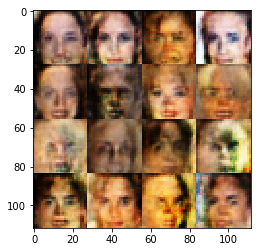

Epoch 1/1... Discriminator Loss: 1.3086... Generator Loss: 0.7077
Epoch 1/1... Discriminator Loss: 1.2628... Generator Loss: 0.7642
Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.7945
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.7188
Epoch 1/1... Discriminator Loss: 1.4679... Generator Loss: 0.7078
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.6386
Epoch 1/1... Discriminator Loss: 1.3202... Generator Loss: 0.7030
Epoch 1/1... Discriminator Loss: 1.2246... Generator Loss: 0.7416
Epoch 1/1... Discriminator Loss: 1.4486... Generator Loss: 0.6425
Epoch 1/1... Discriminator Loss: 1.4665... Generator Loss: 0.6688


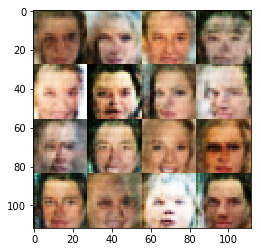

Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.6369
Epoch 1/1... Discriminator Loss: 1.2965... Generator Loss: 0.8133
Epoch 1/1... Discriminator Loss: 1.3442... Generator Loss: 0.7394
Epoch 1/1... Discriminator Loss: 1.3639... Generator Loss: 0.6877
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.6858
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.7395
Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 0.6531
Epoch 1/1... Discriminator Loss: 1.4669... Generator Loss: 0.6014
Epoch 1/1... Discriminator Loss: 1.4265... Generator Loss: 0.6606


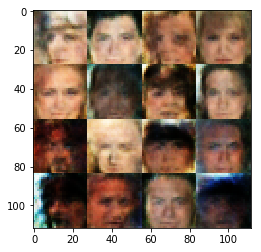

Epoch 1/1... Discriminator Loss: 1.3376... Generator Loss: 0.7227
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.6791
Epoch 1/1... Discriminator Loss: 1.3255... Generator Loss: 0.7887
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.7146
Epoch 1/1... Discriminator Loss: 1.3267... Generator Loss: 0.7237
Epoch 1/1... Discriminator Loss: 1.3112... Generator Loss: 0.6998
Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 0.7399
Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 0.6917
Epoch 1/1... Discriminator Loss: 1.2699... Generator Loss: 0.8010
Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.7468


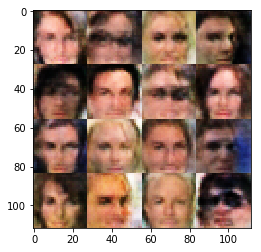

Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.6587
Epoch 1/1... Discriminator Loss: 1.4439... Generator Loss: 0.7107
Epoch 1/1... Discriminator Loss: 1.3694... Generator Loss: 0.6799
Epoch 1/1... Discriminator Loss: 1.3395... Generator Loss: 0.6712
Epoch 1/1... Discriminator Loss: 1.3239... Generator Loss: 0.7251
Epoch 1/1... Discriminator Loss: 1.4463... Generator Loss: 0.5878
Epoch 1/1... Discriminator Loss: 1.2966... Generator Loss: 0.7837
Epoch 1/1... Discriminator Loss: 1.3686... Generator Loss: 0.7275
Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.7419
Epoch 1/1... Discriminator Loss: 1.3319... Generator Loss: 0.6874


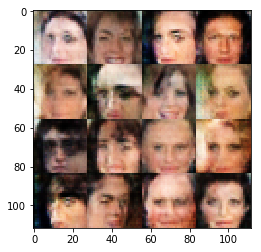

Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.7144
Epoch 1/1... Discriminator Loss: 1.5121... Generator Loss: 0.6615
Epoch 1/1... Discriminator Loss: 1.2466... Generator Loss: 0.7858
Epoch 1/1... Discriminator Loss: 1.3110... Generator Loss: 0.7353
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.7392
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.6501
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.6800
Epoch 1/1... Discriminator Loss: 1.4850... Generator Loss: 0.5795
Epoch 1/1... Discriminator Loss: 1.2791... Generator Loss: 0.7273
Epoch 1/1... Discriminator Loss: 1.2398... Generator Loss: 0.7886


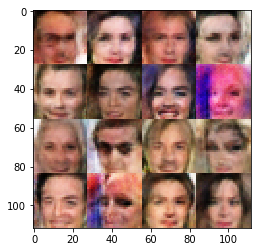

Epoch 1/1... Discriminator Loss: 1.3106... Generator Loss: 0.6599
Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.7256
Epoch 1/1... Discriminator Loss: 1.3555... Generator Loss: 0.6857
Epoch 1/1... Discriminator Loss: 1.3119... Generator Loss: 0.7370
Epoch 1/1... Discriminator Loss: 1.3625... Generator Loss: 0.7579
Epoch 1/1... Discriminator Loss: 1.3383... Generator Loss: 0.6563
Epoch 1/1... Discriminator Loss: 1.2585... Generator Loss: 0.7408
Epoch 1/1... Discriminator Loss: 1.2985... Generator Loss: 0.8004
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.2677... Generator Loss: 0.6847


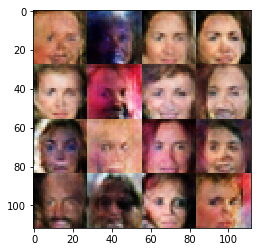

Epoch 1/1... Discriminator Loss: 1.2906... Generator Loss: 0.7141
Epoch 1/1... Discriminator Loss: 1.2820... Generator Loss: 0.6876
Epoch 1/1... Discriminator Loss: 1.3167... Generator Loss: 0.7539
Epoch 1/1... Discriminator Loss: 1.3189... Generator Loss: 0.7348
Epoch 1/1... Discriminator Loss: 1.3402... Generator Loss: 0.6719
Epoch 1/1... Discriminator Loss: 1.3464... Generator Loss: 0.6670
Epoch 1/1... Discriminator Loss: 1.2825... Generator Loss: 0.7423
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.6541
Epoch 1/1... Discriminator Loss: 1.2126... Generator Loss: 0.6836
Epoch 1/1... Discriminator Loss: 1.3284... Generator Loss: 0.6545


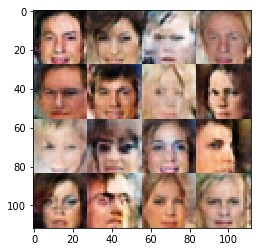

Epoch 1/1... Discriminator Loss: 1.3094... Generator Loss: 0.7060
Epoch 1/1... Discriminator Loss: 1.2022... Generator Loss: 0.8011
Epoch 1/1... Discriminator Loss: 1.3250... Generator Loss: 0.6860
Epoch 1/1... Discriminator Loss: 1.1526... Generator Loss: 0.7704
Epoch 1/1... Discriminator Loss: 1.2721... Generator Loss: 0.6994
Epoch 1/1... Discriminator Loss: 1.3538... Generator Loss: 0.7133
Epoch 1/1... Discriminator Loss: 1.3637... Generator Loss: 0.6508
Epoch 1/1... Discriminator Loss: 1.2877... Generator Loss: 0.7485
Epoch 1/1... Discriminator Loss: 1.2997... Generator Loss: 0.7505
Epoch 1/1... Discriminator Loss: 1.3526... Generator Loss: 0.8456


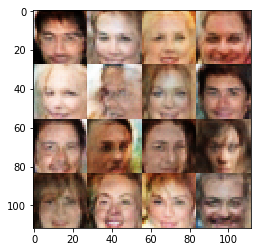

Epoch 1/1... Discriminator Loss: 1.1983... Generator Loss: 0.8343
Epoch 1/1... Discriminator Loss: 1.3396... Generator Loss: 0.7429
Epoch 1/1... Discriminator Loss: 1.3058... Generator Loss: 0.7033
Epoch 1/1... Discriminator Loss: 1.2088... Generator Loss: 0.6893
Epoch 1/1... Discriminator Loss: 1.2718... Generator Loss: 0.7649
Epoch 1/1... Discriminator Loss: 1.3247... Generator Loss: 0.7563
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.7155
Epoch 1/1... Discriminator Loss: 1.2380... Generator Loss: 0.7773
Epoch 1/1... Discriminator Loss: 1.2852... Generator Loss: 0.8583
Epoch 1/1... Discriminator Loss: 1.2454... Generator Loss: 0.7585


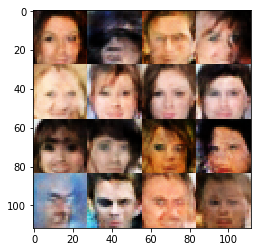

Epoch 1/1... Discriminator Loss: 1.2031... Generator Loss: 0.7725
Epoch 1/1... Discriminator Loss: 1.2791... Generator Loss: 0.7651
Epoch 1/1... Discriminator Loss: 1.2152... Generator Loss: 0.8253
Epoch 1/1... Discriminator Loss: 1.1701... Generator Loss: 0.7397
Epoch 1/1... Discriminator Loss: 1.1736... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 1.3261... Generator Loss: 0.6930


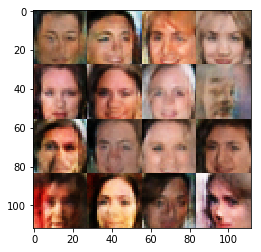

In [55]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.